In [954]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.signal as signal
from sklearn.cluster import KMeans
import circle_fit as cf
from scipy import stats
from scipy import ndimage
import cv2

In [2]:
data_dir = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction/train/sequences/' #6873/000.png'
directories = os.listdir(data_dir)

In [514]:
M,N = 15, 15
lpf = np.zeros((M,N), dtype=np.float32)
D0 = 10 # cut of frequency
n = 30 # order 
for u in range(M):
    for v in range(N):
        D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
        lpf[u,v] = 1 / (1 + (D/D0)**n)

hpf = np.zeros((M,N), dtype=np.float32)
D0 = 300
n = 30
for u in range(M):
    for v in range(N):
        D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
        hpf[u,v] = 1 / (1 + (D0/D)**n)

In [1093]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return np.array([sum_x/length, sum_y/length])

def draw_circle(img, xc, yc, r):
	for i in range(360):
		x = int(xc + r * np.cos(i * np.pi / 180))
		y = int(yc + r * np.sin(i * np.pi / 180))
		img[min(x, img.shape[0]-1), min(y, img.shape[1]-1)] = 255
	return img

def remap_image(img):
	# img = img - img.min()
	return (img / img.max() * 255).astype(int)

def plot_hist(img):
	hist = Counter(img.flatten().tolist())
	all_peak_height = list(hist.values())
	x = np.array(list(hist.keys()))
	plt.figure()
	plt.bar(x, all_peak_height, width=1)
	
def pupil_locate(img, black_threshold=50, estimate_x=(100, 350), estimate_y=(200, 500), plot = False):
	cropped_img = img[estimate_x[0]:estimate_x[1], estimate_y[0]:estimate_y[1]]

	if plot:
		plt.figure()
		plt.imshow(cropped_img, cmap='gray')

	low_pass_filter = np.ones((15, 15))
	smoothed_img = signal.convolve2d(torch.tensor(cropped_img), low_pass_filter, mode='same', fillvalue=255)
	smoothed_img = (smoothed_img / smoothed_img.max() * 255).astype(int)
	low_colors = np.sort(smoothed_img.flatten())[700]
	x, y = np.where(smoothed_img <= low_colors, 255, 0).nonzero()
	coordinates = np.array(list(zip(np.array(x), np.array(y))))
	centroid = centeroidnp(coordinates).astype(int)

	radius = np.max(np.linalg.norm(coordinates - centroid, axis=1))

	return centroid[0]+estimate_x[0], centroid[1]+estimate_y[0], int(radius)

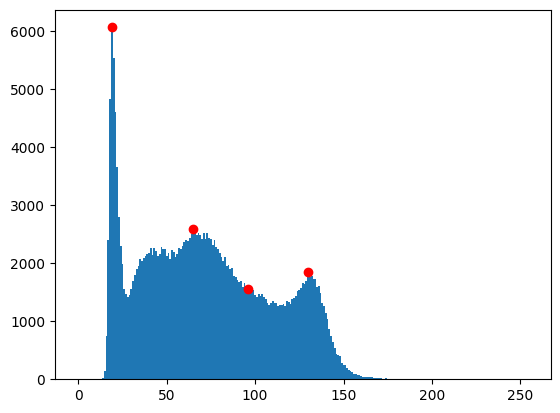

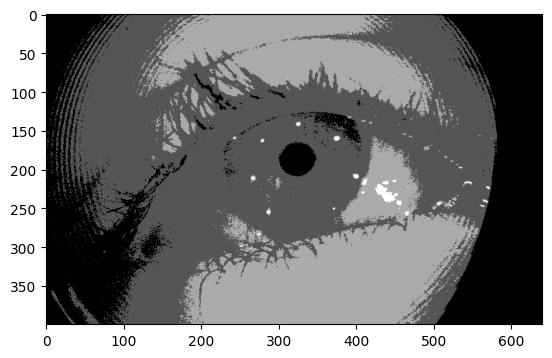

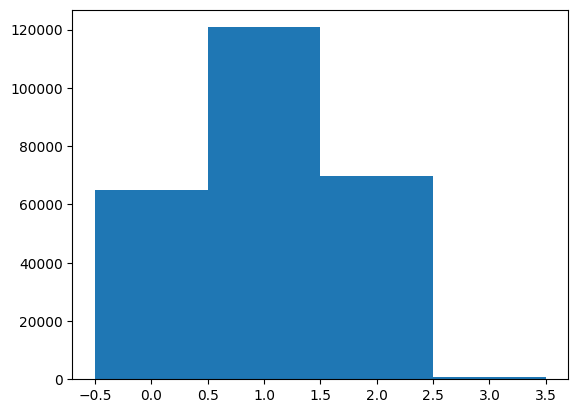

In [1120]:
np.random.shuffle(directories)
directory = directories[0]
files = os.listdir(data_dir + directory)
img_path = data_dir + directory + '/' + np.random.choice(files)
img = remap_image(plt.imread(img_path))

hist = Counter(img.flatten().tolist())
x = list(range(255))
y = [hist[i] if i in hist else 0 for i in x]

peak_x, peak_y = signal.find_peaks(y, height=100, distance=30)
peak_y = peak_y['peak_heights']
if len(peak_y) > 3:
	ind = np.argpartition(peak_y, -3)[-3:]
	top4 = peak_x[ind].tolist()
	top4.append(255)
else:
	top4 = peak_x.tolist()
	top4.append(255)
top4 = np.sort(top4)

bin_centers = (top4[1:]+top4[:-1])/2
img_q = np.digitize(img, bin_centers, right=False)
img_q = np.where(img_q == min(top4), 0, img_q)
plt.figure()
plt.imshow(img_q, cmap='gray')
plot_hist(img_q)